<a href="https://colab.research.google.com/github/luisamariarodriguez/F_monografia_esp_analitica_ciencia_datos_2024./blob/main/Code/010_Preprocesamiento_Iluminacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MEJORA DE ILUMINACIÓN

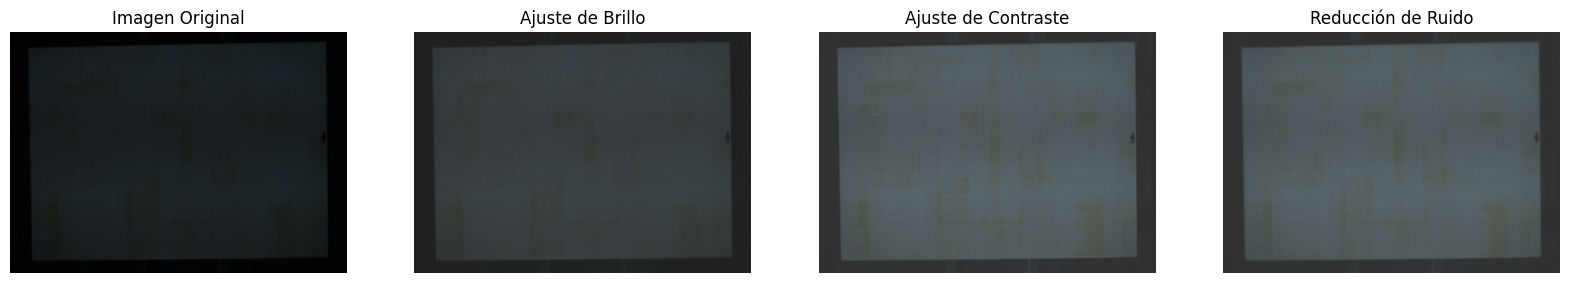

Procesamiento completado.


In [ ]:
# Importar las bibliotecas necesarias
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

# Función para ajustar el brillo
def ajustar_brillo(image, beta=30):
    # beta controla el brillo
    new_image = cv2.convertScaleAbs(image, beta=beta)
    return new_image

# Función para ajustar el contraste
def ajustar_contraste(image, alpha=1.5):
    # alpha controla el contraste
    new_image = cv2.convertScaleAbs(image, alpha=alpha)
    return new_image

# Función para mejorar una imagen
def mejorar_imagen(image_path, output_folder):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"No se pudo cargar la imagen: {image_path}")
        return

    # Guardar imagen original
    original_path = os.path.join(output_folder, '1_imagen_original.jpg')
    cv2.imwrite(original_path, image)

    # Ajustar brillo
    brightness_adjusted = ajustar_brillo(image)
    brightness_path = os.path.join(output_folder, '2_ajuste_brillo.jpg')
    cv2.imwrite(brightness_path, brightness_adjusted)

    # Ajustar contraste
    contrast_adjusted = ajustar_contraste(brightness_adjusted)
    contrast_path = os.path.join(output_folder, '3_ajuste_contraste.jpg')
    cv2.imwrite(contrast_path, contrast_adjusted)

    # Reducción de ruido
    denoised_image = cv2.bilateralFilter(contrast_adjusted, 9, 50, 50)
    denoised_path = os.path.join(output_folder, '4_reduccion_ruido.jpg')
    cv2.imwrite(denoised_path, denoised_image)

    # Mostrar las imágenes en secuencia
    images = [original_path, brightness_path, contrast_path, denoised_path]
    titles = ['Imagen Original', 'Ajuste de Brillo', 'Ajuste de Contraste', 'Reducción de Ruido']

    plt.figure(figsize=(20, 10))  # Ajustar el tamaño de la figura
    for i in range(4):
        img = cv2.imread(images[i])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img_rgb)
        plt.title(titles[i])
        plt.axis('off')

    plt.show()

# Crear la carpeta de destino si no existe
output_folder = '/content/proceso_mejoras'
os.makedirs(output_folder, exist_ok=True)

# Ruta de la imagen de origen subida a Colab
input_image = '/content/Mancha-02-03-2024-04-16-05.jpg'  # Cambia esto a la ruta de tu imagen en Colab

# Mejorar la imagen y guardar cada paso
mejorar_imagen(input_image, output_folder)

print("Procesamiento completado.")



# Disminución de resolución y eliminación de ruido de fondo

In [ ]:
import cv2
import os
import numpy as np
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive', force_remount=True)

# Función para ajustar el brillo y el contraste
def ajustar_brillo_contraste(image, alpha=1.5, beta=30):
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

# Función para aumentar la resolución de la imagen
def aumentar_resolucion(image, factor=10):
    new_size = (int(image.shape[1] * factor), int(image.shape[0] * factor))
    image_aumentada = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)
    return image_aumentada

# Función para reducir la resolución de la imagen a 400x560
def reducir_resolucion_a(image, new_size=(560, 400)):
    image_reducida = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)
    return image_reducida

# Función para detectar bordes, encontrar esquinas y rellenar el área fuera del rectángulo con blanco
def detectar_esquinas_rellenar(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Aplicar umbralización adaptativa para obtener una imagen binaria
    _, binary = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Aplicar operaciones morfológicas para limpiar la imagen binaria
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # Detección de bordes utilizando el detector de bordes de Canny con parámetros ajustados
    edges = cv2.Canny(binary, 50, 150)

    # Encontrar contornos en la imagen de bordes
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return image, image  # Si no hay contornos, devolver la imagen original

    # Encontrar el contorno con el área más grande
    contour = max(contours, key=cv2.contourArea)
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Crear una copia de la imagen para mostrar las esquinas
    image_with_corners = image.copy()

    # Crear una máscara blanca del mismo tamaño que la imagen
    mask = np.ones_like(image) * 255

    if len(approx) == 4:
        for point in approx:
            cv2.circle(image_with_corners, tuple(point[0]), 10, (0, 0, 255), -1)  # Marcar esquinas con un círculo rojo

        # Dibujar el contorno en la máscara
        cv2.drawContours(mask, [approx], -1, (0, 0, 0), thickness=cv2.FILLED)
    else:
        # Dibujar el rectángulo delimitador en la máscara si no se encuentran 4 esquinas
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(mask, (x, y), (x+w, y+h), (0, 0, 0), thickness=cv2.FILLED)

    # Invertir la máscara
    mask_inv = cv2.bitwise_not(mask)

    # Rellenar el área exterior al contorno más grande con blanco en la imagen original
    image_filled = cv2.bitwise_and(image, mask_inv) + cv2.bitwise_and(np.ones_like(image) * 255, mask)

    # Comprobar si más del 50% de la imagen resultante es blanca
    gray_with_mask = cv2.cvtColor(image_filled, cv2.COLOR_BGR2GRAY)
    num_white_pixels = np.sum(gray_with_mask == 255)
    total_pixels = gray_with_mask.size

    if num_white_pixels / total_pixels > 0.5:
        return image, image_with_corners  # Si más del 50% es blanca, devolver la imagen original

    return image_filled, image_with_corners
# Función para mejorar una imagen
def mejorar_imagen(image_path, output_path, scale_up_factor=10, final_size=(560, 400)):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"No se pudo cargar la imagen: {image_path}")
        return

    # Aumentar la resolución de la imagen
    image_aumentada = aumentar_resolucion(image, factor=scale_up_factor)

    # Ajustar brillo y contraste antes del recorte
    adjusted_image_before_crop = ajustar_brillo_contraste(image_aumentada)

    # Detectar las esquinas y rellenar el área exterior al rectángulo
    image_filled, image_with_corners = detectar_esquinas_rellenar(adjusted_image_before_crop)

    # Ajustar brillo y contraste después del recorte
    adjusted_image = ajustar_brillo_contraste(image_filled)

    # Aplicar reducción de ruido usando el filtro bilateral
    denoised_image = cv2.bilateralFilter(adjusted_image, 9, 50, 50)

    # Reducir la resolución de la imagen a 400x560
    final_image = reducir_resolucion_a(denoised_image, new_size=final_size)

    # Guardar la imagen transformada y mejorada
    cv2.imwrite(output_path, final_image)
    print(f"Imagen mejorada guardada en: {output_path}")

# Ruta de la carpeta de origen y la carpeta de destino en Google Drive
input_folder = '/content/drive/My Drive/muestra_PIXAI_final/buenas_modelo_segmentacion_train'
output_folder = '/content/drive/My Drive/muestra_PIXAI_final/pixai_anomaly_detection_6/train/good'

# Verificar si la carpeta de origen existe
if not os.path.exists(input_folder):
    print(f"La carpeta de origen no existe: {input_folder}")
else:
    # Crear la carpeta de destino si no existe
    os.makedirs(output_folder, exist_ok=True)

    # Procesar cada imagen en la carpeta de origen
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)
            mejorar_imagen(input_path, output_path)

    print("Procesamiento completado.")


# Ajustes geométricos y recortes de fondo

In [ ]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

# Función para ajustar la rotación de la imagen
def ajustar_rotacion(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Aplicar la detección de bordes de Canny
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    # Encontrar líneas en la imagen usando la Transformada de Hough
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=200, minLineLength=150, maxLineGap=20)

    if lines is not None:
        # Calcular el ángulo promedio de las líneas detectadas
        angles = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
            if abs(angle) < 5:  # Considerar solo líneas casi horizontales (ajustado a 5 grados)
                angles.append(angle)

        if len(angles) > 0:
            # Calcular el ángulo de rotación promedio
            median_angle = np.median(angles)
        else:
            median_angle = 0
    else:
        median_angle = 0

    # Rotar la imagen para corregir la inclinación
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, median_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return rotated

# Función para recortar la figura principal de la imagen
def recortar_figura_principal(image_path, output_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Ajustar la rotación de la imagen
    rotated_image = ajustar_rotacion(image)

    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)

    # Aplicar un umbral para crear una máscara binaria del objeto
    _, binary_mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

    # Encontrar contornos en la imagen de máscara
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Encontrar el contorno más grande
    if contours:
        max_contour = max(contours, key=cv2.contourArea)

        # Encontrar el rectángulo delimitador del contorno más grande
        x, y, w, h = cv2.boundingRect(max_contour)

        # Recortar la imagen usando el rectángulo delimitador
        cropped_image = rotated_image[y:y+h, x:x+w]

        # Guardar la imagen recortada
        cv2.imwrite(output_path, cropped_image)
    else:
        print(f"No se encontraron contornos en la imagen: {image_path}")

# Rutas de las carpetas de entrada y salida
input_folder = '/content/drive/My Drive/muestra_PIXAI_final/pixai_anomaly_detection_8/test/anomaly'
output_folder = '/content/drive/My Drive/muestra_PIXAI_final/pixai_anomaly_detection_10/test/anomaly'

# Verificar si la carpeta de entrada existe
if not os.path.exists(input_folder):
    print(f"La carpeta de entrada no existe: {input_folder}")
else:
    # Crear la carpeta de salida si no existe
    os.makedirs(output_folder, exist_ok=True)

    # Procesar cada imagen en la carpeta de entrada
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)
            recortar_figura_principal(input_path, output_path)

    print("Procesamiento completado.")


Procesamiento completado.
